In [90]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [91]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [92]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [93]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [94]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# Get the table names from the database
table_names = Base.classes.keys()

# View all of the classes that automap found
table_names

/var/folders/ds/jk39g9xd62v_5kxdlxcxn0800000gn/T/ipykernel_16993/2069772277.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


['measurement', 'station']

In [95]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [96]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [97]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date


'2017-08-23'

#### Design a query to retrieve the last 12 months of precipitation data and plot the results,</br> starting from the most recent data point in the database. 

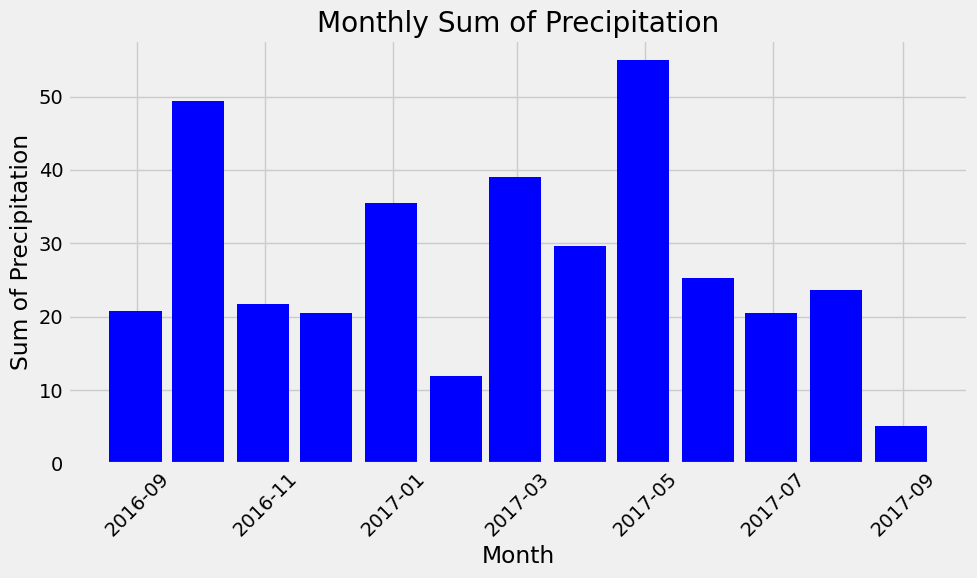

In [98]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the date one year previous
from_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_previous = from_date - timedelta(days=365)

# Query column names from Measurement table
column_names = [column.key for column in Measurement.__table__.columns]

# Query data from Measurement table 
row_data = session.query(Measurement).all()

# Convert query result to a list of dictionaries
data = [measurement.__dict__ for measurement in row_data]

# Create a DataFrame 
M_data = pd.DataFrame(data, columns=column_names)

# Convert 'date' column to datetime format
M_data['date'] = pd.to_datetime(M_data['date'])

# Filter data for the previous year
year_precip = M_data[(M_data['date'] >= one_year_previous) & (M_data['date'] <= from_date)]

# Group the data by month and calculate the sum of precipitation for each month
monthly_sum_df = year_precip.set_index('date').resample('M').sum()

# Reset the index for plotting
monthly_sum_df.reset_index(inplace=True)

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the bar chart
plt.bar(monthly_sum_df['date'], monthly_sum_df['prcp'], width=25, color='blue', align='center')

# Configure the plot
plt.xlabel('Month')
plt.ylabel('Sum of Precipitation')
plt.title('Monthly Sum of Precipitation')
plt.xticks(rotation=45)  

# Show the plot
plt.tight_layout()  
plt.show()




In [99]:
year_precip

,id,station,date,prcp,tobs
2363,2364,USC00519397,2016-08-23,0.00,81.0
2364,2365,USC00519397,2016-08-24,0.08,79.0
2365,2366,USC00519397,2016-08-25,0.08,80.0
2366,2367,USC00519397,2016-08-26,0.00,79.0
2367,2368,USC00519397,2016-08-27,0.00,77.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [100]:
# Use Pandas to calculate the summary statistics for the precipitation data

prcp_summary = pd.DataFrame(year_precip['prcp'].describe())

prcp_summary




,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [101]:
# Design a query to calculate the total number of stations in the dataset

station_col_names = [column.key for column in Station.__table__.columns]
station_rows = session.query(Station).all()
station_data = [s.__dict__ for s in station_rows]

Stations = pd.DataFrame(station_data, columns=station_col_names)

print('The number of Stations is: ', Stations['station'].nunique())

The number of Stations is:  9


In [102]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


station_counts = M_data.groupby('station').size()

station_counts.sort_values(ascending=False)

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
dtype: int64

In [103]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active = station_counts.nlargest(1).index[0]

most_active_df = M_data[M_data['station'] == most_active]

mas_lo = most_active_df['tobs'].min()
mas_hi = most_active_df['tobs'].max()
mas_avg = most_active_df['tobs'].mean()

print(f'Lowest Temp: {mas_lo}')
print(f'Highest Temp: {mas_hi}')
print(f'Average Temp: {mas_avg}')

Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66378066378067


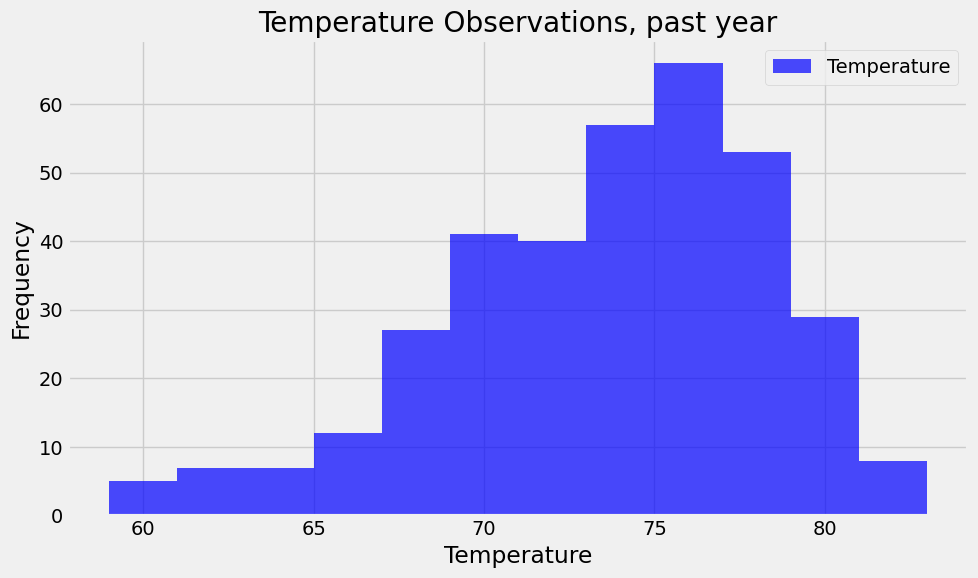

In [104]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

mas_temp_1yr = year_precip[year_precip['station'] == most_active]

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a histogram of temperatures with 12 bins
plt.hist(mas_temp_1yr['tobs'], bins=12, color='blue', alpha=0.7)

# Configure the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations, past year')
plt.legend(['Temperature'], loc='upper right')

# Show the plot
plt.tight_layout()  
plt.show()



### Close Session

In [105]:
session.close

<bound method Session.close of <sqlalchemy.orm.session.Session object at 0x124e133a0>>